In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
import pandas as pd
import zipfile, os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [4]:
# ✅ Step 2: Extract the ZIP file
zip_path = "/content/archive (3).zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/fer2013")

print("Extracted files:", os.listdir("/content/fer2013"))


Extracted files: ['test', 'train']


In [6]:
# ✅ Step 1: Transformations (resize, normalize, augment)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # ensure single channel
    transforms.Resize((48,48)),                   # FER images are 48x48
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# ✅ Step 2: Load dataset from folders
train_dataset = datasets.ImageFolder(root="/content/fer2013/train", transform=transform)
test_dataset  = datasets.ImageFolder(root="/content/fer2013/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [7]:
print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")
print("Classes:", train_dataset.classes)

# ✅ Step 3: Define CNN Model
class EmotionCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(128*6*6, 256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, len(train_dataset.classes))  # auto detect number of classes
        )
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionCNN().to(device)

# ✅ Step 4: Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ✅ Step 5: Training Loop
for epoch in range(5):  # train a few epochs
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

# ✅ Step 6: Evaluation
correct, total = 0, 0
model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {100*correct/total:.2f}%")

Train size: 28709, Test size: 7178
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Epoch 1, Loss: 1.6473
Epoch 2, Loss: 1.4181
Epoch 3, Loss: 1.3088
Epoch 4, Loss: 1.2353
Epoch 5, Loss: 1.1812
Test Accuracy: 55.99%


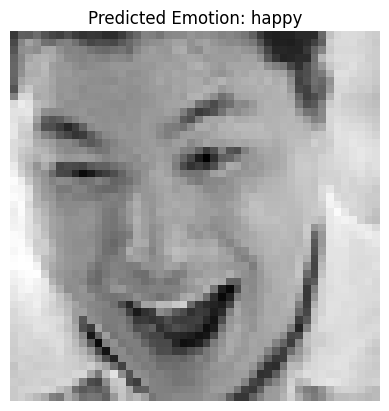

In [13]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = "/content/fer2013/test/happy/PrivateTest_10736786.jpg"

img = Image.open(img_path).convert("L")

img_tensor = transform(img).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model(img_tensor)
    pred = torch.argmax(output, dim=1).item()

pred_class = train_dataset.classes[pred]

plt.imshow(img, cmap="gray")
plt.title(f"Predicted Emotion: {pred_class}")
plt.axis("off")
plt.show()
